In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import train_test_split
import lightgbm as lgbm
from sklearn.metrics import confusion_matrix, accuracy_score
from pycaret.classification import *

In [2]:
seed = 42
np.random.seed(seed)
set_config('seed', seed)

# 1. 데이터 로드

In [3]:
train=pd.read_csv('input/train.csv', index_col=0)#, na_values='?') #인덱스 col=0도 check!
test=pd.read_csv('input/test.csv', index_col=0)#, na_values='?')
submission=pd.read_csv('input/sample_submission.csv', index_col=0)  

In [4]:
train['income']=pd.factorize(train['income'], sort=True)[0]

In [ ]:
train.shape, test.shape

In [ ]:
train.head(3)
test.head(3)

# 2. EDA & 전처리

In [ ]:
train.info()
train.describe()
train.describe(include='O')

## Missing Value

In [ ]:
train.isnull().sum()#.sum()
test.isnull().sum()#.sum()

### outlier

### education

In [5]:
train.drop(['education'],axis=1, inplace=True)
test.drop(['education'],axis=1, inplace=True)

### capital_gain 99999

In [6]:
df = pd.concat([train, test])
df.shape

(32561, 14)

In [7]:
df['capital_gain_imsi'] = df['capital_gain'].replace(99999,0)

In [8]:
capital_gain_imsi = pd.DataFrame(df.groupby(['education_num'])['capital_gain_imsi'].mean()).reset_index()

In [9]:
train = train.merge(capital_gain_imsi, on=['education_num'], how='left')
test = test.merge(capital_gain_imsi, on=['education_num'], how='left')

In [10]:
train.loc[train.capital_gain == 99999, 'capital_gain'] = train['capital_gain_imsi']
test.loc[test.capital_gain == 99999, 'capital_gain'] = test['capital_gain_imsi']

In [11]:
train.drop(['capital_gain_imsi'],axis=1, inplace=True)
test.drop(['capital_gain_imsi'],axis=1, inplace=True)

In [12]:
train['edu_imsi'] = train.education_num
train.loc[((train.education_num == 2) | (train.education_num == 3) | (train.education_num == 4) | (train.education_num == 5) | (train.education_num == 7)), 'edu_imsi'] = 2
train.loc[((train.education_num == 6) | (train.education_num == 8)), 'edu_imsi'] = 6
train.loc[((train.education_num == 11) | (train.education_num == 12)), 'edu_imsi'] = 11 
train.loc[((train.education_num == 15) | (train.education_num == 16)), 'edu_imsi'] = 15

In [13]:
test['edu_imsi'] = test.education_num
test.loc[((test.education_num == 2) | (test.education_num == 3) | (test.education_num == 4) | (test.education_num == 5) | (test.education_num == 7)), 'edu_imsi'] = 2
test.loc[((test.education_num == 6) | (test.education_num == 8)), 'edu_imsi'] = 6
test.loc[((test.education_num == 11) | (test.education_num == 12)), 'edu_imsi'] = 11 
test.loc[((test.education_num == 15) | (test.education_num == 16)), 'edu_imsi'] = 15

In [14]:
train['imsi'] = train.capital_gain*train.hours_per_week#*train.capital_loss
test['imsi'] = test.capital_gain*test.hours_per_week#*train.capital_loss

# 3. 모델 학습

In [ ]:
import gc
gc.collect()

In [ ]:
train.columns

In [35]:
%%time
clf = setup(session_id=seed, 
            data = train, target = 'income'
          #, categorical_features=['capital_gubun']
          #, numeric_features = ['education_num']
          , ignore_features =['fnlwgt','education_num']
           )

Setup Succesfully Completed!


,Description,Value
0,session_id,42
1,Target Type,Binary
2,Label Encoded,"0: 0, 1: 1"
3,Original Data,"(26049, 16)"
4,Missing Values,False
5,Numeric Features,6
6,Categorical Features,9
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


Wall time: 4.92 s


In [36]:
best_3 = compare_models(sort = 'F1', n_select = 3
                       ,exclude=['lr', 'knn', 'nb', 'dt', 'svm', 'rbfsvm', 'ridge','qda']
                       #,exclude=['lr', 'knn', 'nb', 'dt', 'svm', 'rbfsvm', 'gpc', 'mlp', 'ridge', 'rf', 'qda', 'ada', 'xgboost']
                       )

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,Extreme Gradient Boosting,0.8644,0.9210,0.6442,0.7593,0.6969,0.6103,0.6138,2.9164
1,CatBoost Classifier,0.8661,0.9240,0.6361,0.7711,0.6969,0.6120,0.6168,13.1468
2,Light Gradient Boosting Machine,0.8620,0.9219,0.6387,0.7541,0.6913,0.6033,0.6069,0.2977
3,Gradient Boosting Classifier,0.8628,0.9181,0.5957,0.7859,0.6775,0.5925,0.6018,1.8582
4,Ada Boost Classifier,0.8554,0.9124,0.6173,0.7425,0.6739,0.5820,0.5863,0.7435
5,Linear Discriminant Analysis,0.8464,0.8988,0.5782,0.7316,0.6454,0.5492,0.5557,0.1911
6,Random Forest Classifier,0.8362,0.8652,0.5830,0.6923,0.6327,0.5283,0.5317,0.1246
7,Extra Trees Classifier,0.8223,0.8469,0.5953,0.6447,0.6187,0.5032,0.5040,0.5693


In [37]:
blended = blend_models(estimator_list = best_3, fold = 5, method = 'soft')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8653,0.9207,0.6375,0.7665,0.6961,0.6105,0.6148
1,0.8625,0.9169,0.6472,0.7505,0.6950,0.6069,0.6097
2,0.8609,0.9230,0.6181,0.7625,0.6828,0.5950,0.6003
3,0.8711,0.9302,0.6386,0.7880,0.7055,0.6241,0.6298
4,0.8754,0.9267,0.6715,0.7830,0.7230,0.6432,0.6464
Mean,0.8670,0.9235,0.6426,0.7701,0.7005,0.6159,0.6202
SD,0.0054,0.0046,0.0173,0.0137,0.0134,0.0165,0.0162


In [38]:
pred_holdout = predict_model(blended)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.8753,0.9295,0.6563,0.7929,0.7182,0.6391,0.6438


In [23]:
%%time
final_model = finalize_model(blended)

Wall time: 4min 14s


In [24]:
predictions = predict_model(final_model, data = test)

# 4. 예측

In [25]:
submission['prediction'] = predictions['Label']

# 5. 제출

In [26]:
submission.to_csv('output/20201027-1.csv')

In [27]:
xgboost = create_model('xgboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8630,0.9202,0.6181,0.7702,0.6858,0.5995,0.6055
1,0.8520,0.9146,0.6440,0.7158,0.6780,0.5823,0.5837
2,0.8653,0.9225,0.6764,0.7438,0.7085,0.6212,0.6223
3,0.8487,0.9100,0.6071,0.7220,0.6596,0.5633,0.5668
4,0.8550,0.9062,0.6149,0.7422,0.6726,0.5805,0.5847
5,0.8660,0.9296,0.6408,0.7674,0.6984,0.6132,0.6173
6,0.8754,0.9334,0.6634,0.7885,0.7206,0.6411,0.6451
7,0.8636,0.9203,0.6472,0.7547,0.6969,0.6096,0.6126
8,0.8652,0.9283,0.6311,0.7708,0.6940,0.6086,0.6136
9,0.8723,0.9245,0.6796,0.7664,0.7204,0.6380,0.6400


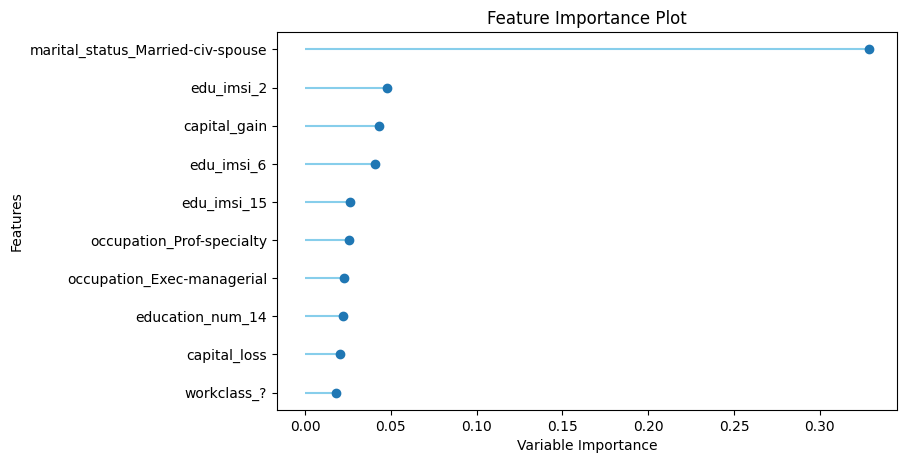

In [28]:
plot_model(estimator = xgboost, plot = 'feature')

In [29]:
lightgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8630,0.9204,0.6214,0.7680,0.6869,0.6005,0.6060
1,0.8551,0.9140,0.6408,0.7279,0.6816,0.5883,0.5903
2,0.8661,0.9210,0.6699,0.7500,0.7077,0.6212,0.6229
3,0.8542,0.9133,0.6136,0.7383,0.6702,0.5777,0.5817
4,0.8558,0.9105,0.6214,0.7413,0.6761,0.5842,0.5880
5,0.8652,0.9332,0.6311,0.7708,0.6940,0.6086,0.6136
6,0.8793,0.9343,0.6667,0.8016,0.7279,0.6512,0.6558
7,0.8605,0.9190,0.6505,0.7417,0.6931,0.6033,0.6055
8,0.8652,0.9279,0.6343,0.7686,0.6950,0.6095,0.6142
9,0.8746,0.9228,0.6926,0.7670,0.7279,0.6467,0.6481


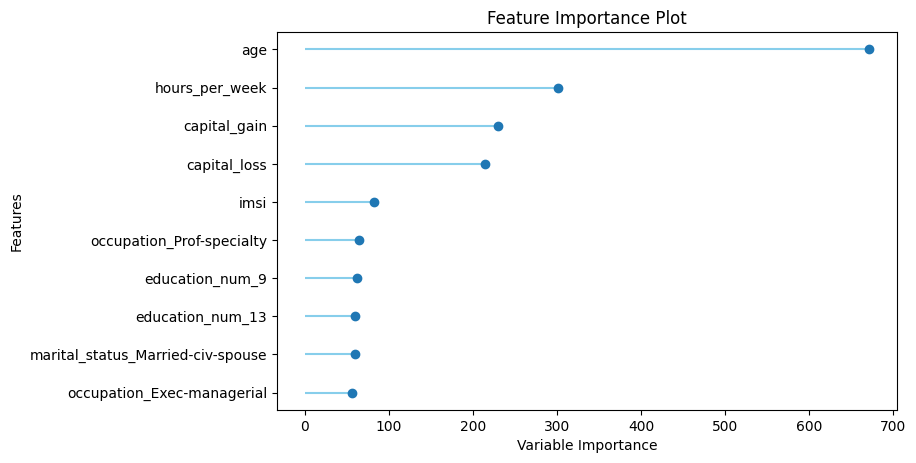

In [30]:
plot_model(estimator = lightgbm, plot = 'feature')